In [ ]:
# Milestone 4 : Contrat de maintenance – Simulations
# Livrable :
# 
# Notebook de simulation d’évolution des clusters.
# Problèmes et erreurs courants :
# 
# Erreur consistant à ne pas utiliser le « transformer » StandardScaler du fichier qui a servi à l’entraînement du modèle (« fit » du modèle).
# Erreur consistant à comparer des listes de clusters prédits à 2 dates différentes (cela ne concerne pas les mêmes clients et pas le même nombre, ni les mêmes données de clients).
# Recommandations :
# 
# L’objectif est de déterminer au bout de combien de temps le modèle de clustering entraîné initialement proposé (donc « fit ») devient obsolète (quand les prédictions, « predict », ne sont plus pertinentes), nécessitant d’entraîner un nouveau modèle de clustering.
# Pour prendre un exemple, supposons que l’entraînement du modèle initial M0 ait été réalisé à T0 pour un fichier clients F0, qui donne la liste des numéros de clusters C0, C0=M0.fit(F0).
# À T1=T0 +n jours, un nouveau modèle M1 est entraîné sur le nouveau fichier clients F1 à T1, et donne une nouvelle liste de clusters C1, C1_new = M1.fit(F1).
# Si on utilise le modèle initial M0, à T1 la prédiction des numéros de clusters du fichier F1 des clients à T1 donne C1_init = M0.predict(F1).
# Il s’agit de comparer les numéros de clusters à T1 du fichier F1, selon que l’on utilise le modèle initial créé à T0(M0) via un « predict », ou le modèle créé à T1 via un « fit ».
# Pour un k-means, les numéros de clusters ne correspondent pas forcément d’une simulation à l’autre. Pour mesurer la divergence des clusters, il est conseillé d’utiliser l’ARI, indépendant de la numérotation des clusters.
# Il s’agit donc de simuler plusieurs périodes T1, T2 à Tt, et d’afficher l’évolution de l’ARI. Si l’ARI passe en dessous de 0.8 (correspond environ à 0,9 en accuracy), il est sûrement pertinent de reproposer un entraînement de modèle au client.
# Le fichier clients Fi à date Ti sera créé à partir de toutes les commandes passées jusqu’à Ti. Une fonction permettra de générer ce fichier juste en passant la date du fichier (filtrage de toutes les commandes jusqu’à Ti et création des features).
# Attention, les fichiers Fi sont les fichiers clients transformés par un StandardScaler, celui qui a servi à standardiser les données d’entraînement du modèle concerné. Donc pour le calcul de C1_init, il faut utiliser le StandardScaler du modèle M0 (fit sur le F0), et pour C1_new, celui du M1 (fit sur le F1).
# Le délai entre 2 simulations (« n jours » entre Ti et Ti+1) doit être suffisamment court pour déterminer assez précisément le délai de maintenance du modèle (1 semaine, 15 jours).
# La date de début T0 doit être la plus proche possible de la date de fin du fichier (août 2018), tout en intégrant le délai de simulation de maintenance, non connu au départ. Il faudra donc procéder par itération. Par exemple tester avec T0 au 31/12/2017, et si le délai de maintenance déterminé est de 3 mois (ARI <0.8), refaire une simulation à T0 = août 2018 – 3 ou 4 mois, soit avril ou mai 2018, pour finir la simulation courant août au plus près de la date du fichier complet.
# Une autre solution est de faire une simulation en marche arrière, en faisant attention à faire le « predict » sur le modèle le plus ancien.
# Il peut être intéressant, mais pas obligatoire, de calculer l’accuracy à la place de l’ARI, ce qui nécessite de « recaler » les numéros de clusters entre les 2 listes. Ceci peut se faire en réalisant une matrice de confusion et en utilisant la fonction argmax() pour déterminer la translation de numéro de cluster. Cette transformation ne fonctionne que si l’accuracy est élevée.
# Il peut être intéressant, mais pas obligatoire, de regarder la divergence des clusters par numéro de cluster, le but étant de s’assurer de la stabilité en priorité des clusters de « bons clients ».

In [1]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import cluster, preprocessing, metrics

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import adjusted_rand_score

from sklearn.pipeline import make_pipeline


In [2]:
def cluster_analyzer(_Xy) -> pd.DataFrame:
    """
    Cluster analyzer function
    :param _Xy: Dataframe with features and targets
    :return: Dataframe with colored features
    """
    clusters = pd.DataFrame(_Xy.groupby('cluster').mean())
    fig, ax = plt.subplots(len(_Xy.columns) - 1, 1, figsize=(8, 4 * len(_Xy.columns)), sharex=False, sharey=True)
    for i, col in enumerate(_Xy.drop(columns='cluster').columns):
        # print("-- Cluster ", _cluster, " --")
        plt.suptitle(f"Clusters box plots")
        sns.boxplot(data=_Xy,
                    y=_Xy[col],
                    # vert=False,
                    showmeans=True,
                    ax=ax[i],
                    hue='cluster',
                    palette='bright',
                    )
        ax[i].set_title(f"Feature {col}")

    plt.show()
    print("-- " * 20)
    return clusters.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1, axis=1)

In [3]:
def get_dataset(dataset_name) -> pd.DataFrame:
    """
    Load dataset from csv file
    :param dataset_name: Name of the dataset
    :return: Dataframe with features
    """
    datasets = {
        "customers": pd.read_csv('../data/extracts/tables/customers.csv', index_col='index'),
        "geoloc": pd.read_csv("../data/extracts/tables/geoloc.csv", index_col='index'),
        "items": pd.read_csv('../data/extracts/tables/order_items.csv', index_col='index'),
        "payments": pd.read_csv('../data/extracts/tables/order_pymts.csv', index_col='index'),
        "reviews": pd.read_csv('../data/extracts/tables/order_reviews.csv', index_col='index'),
        "orders": pd.read_csv('../data/extracts/tables/orders.csv', index_col='index'),
        "products": pd.read_csv('../data/extracts/tables/products.csv', index_col='index'),
        "sellers": pd.read_csv('../data/extracts/tables/sellers.csv', index_col='index'),
    }
    datasets['orders']["order_purchase_timestamp"] = pd.to_datetime(datasets['orders']["order_purchase_timestamp"])
    
    return datasets[dataset_name].copy()
        

In [4]:
def get_min_max_dates(orders) -> (datetime, datetime):
    """
    Get min and max dates
    :param orders: Dataframe with orders
    :return: min and max dates
    """
    date_min = orders["order_purchase_timestamp"].min()
    date_max = orders['order_purchase_timestamp'].max()
    return date_min, date_max

In [5]:
def make_fresh_cls(n_clusters:int=4) -> cluster.KMeans:
    """
    Make Fresh KMeans
    :param n_clusters: Number of clusters
    :return: Kmeans clustering object
    """
    return cluster.KMeans(random_state=42, n_clusters=n_clusters)

In [6]:
def extract_features(_endtime: datetime = None) -> pd.DataFrame:
    """
    Extract features from dataframe
    :param _endtime: End time of the dataset
    :return: Dataframe with features until _endtime
    """

    _orders_df = get_dataset('orders')
    
    if _endtime is not None:
        mask = _orders_df["order_purchase_timestamp"] < _endtime
        _orders_df = _orders_df.loc[mask]
    
    orders_dates = get_min_max_dates(_orders_df)
    print(f"start: {orders_dates[0]} / end: {orders_dates[-1]} | Total = {(orders_dates[-1]-orders_dates[0]).days} days")
    print(f"total : {orders_dates[1]-orders_dates[0]}")
    
    customers_df = get_dataset('customers')
    payments_df = get_dataset('payments')
    reviews_df = get_dataset('reviews')
    
    # Recency
    present_day = _orders_df['order_purchase_timestamp'].max() + timedelta(days=1)
    df_orders_customers = pd.merge(_orders_df, customers_df, on="customer_id")
    df_recency = pd.DataFrame(
        df_orders_customers.groupby(by='customer_unique_id', as_index=False)['order_purchase_timestamp'].max())
    df_recency['Recency'] = df_recency['order_purchase_timestamp'].apply(lambda x: (present_day - x).days)
    df_recency.drop(columns=['order_purchase_timestamp'], inplace=True)
    df_recency.set_index('customer_unique_id', drop=True, inplace=True)

    # Frequency
    df_orders_customers = pd.merge(_orders_df, customers_df, on="customer_id")
    df_frequency = pd.DataFrame(
        df_orders_customers.groupby(["customer_unique_id"]).agg({"order_id": "nunique"}).reset_index())
    df_frequency.rename(columns={"order_id": "Frequency"}, inplace=True)
    df_frequency.set_index('customer_unique_id', drop=True, inplace=True)

    # Monetary
    df_payments = payments_df.groupby("order_id")["payment_value"].sum().reset_index()
    df_orders_customers = pd.merge(_orders_df, customers_df, on="customer_id", how="left")
    df_monetary = pd.merge(df_orders_customers, df_payments, on="order_id", how="left")
    df_monetary = df_monetary.groupby("customer_unique_id")["payment_value"].sum().reset_index()
    df_monetary.rename(columns={"payment_value": "Monetary"}, inplace=True)
    df_monetary.set_index('customer_unique_id', drop=True, inplace=True)

    # Review score
    review_min = reviews_df.groupby("order_id")["review_score"].min()
    df_orders_reviews = pd.merge(_orders_df, review_min, on="order_id", how="left")
    df_customers_orders_reviews = pd.merge(df_orders_reviews, customers_df, on="customer_id", how="left")
    df_reviews_min = df_customers_orders_reviews.groupby('customer_unique_id')["review_score"].min()
    df_reviews_min.shape, df_reviews_min.isna().sum().item()
    
    # Review Score Imputation
    mean_score = df_reviews_min.mean()
    df_reviews_min = pd.DataFrame(df_reviews_min)
    df_reviews_min.loc[df_reviews_min.review_score.isna(), 'review_score'] = mean_score
    df_reviews_min.shape, df_reviews_min.isna().sum().item(), df_reviews_min.head()

    # Merging Features
    features = df_recency.join(df_frequency, how='left')
    features = features.join(df_monetary, how='right')
    features = features.merge(df_reviews_min, left_index=True, right_index=True, how="left", copy=True)

    return features.copy()

In [7]:
from sklearn.pipeline import Pipeline

def make_cls_pipeline(_X, _cls = None) -> Pipeline:
    """
    Make Pipeline with KMeans clustering and feature selection
    :param _X: Dataframe with features
    :param _cls: KMeans clustering
    :return: Pipeline with KMeans clustering and feature selection
    """
    if _cls is None:
        _cls = make_fresh_cls()
    
    numerical_columns_selector = make_column_selector(dtype_exclude=object)
    numerical_columns = numerical_columns_selector(_X)

    numerical_preprocessor_minmax = preprocessing.MinMaxScaler((-1, 1))
    # numerical_preprocessor_standard = preprocessing.StandardScaler()

    numerical_preprocessor_log = preprocessing.FunctionTransformer(
        func=np.log1p,
        inverse_func=np.expm1,
        feature_names_out='one-to-one'
    )

    # numerical_pipeline = make_pipeline(numerical_preprocessor_standard)
    numerical_pipeline = make_pipeline(numerical_preprocessor_minmax)
    # numerical_pipeline = make_pipeline(numerical_preprocessor_log, numerical_preprocessor_minmax)

    # preprocessor
    preprocessor = ColumnTransformer([("NUM", numerical_pipeline, numerical_columns)])
    preprocessor.fit_transform(_X)
    
    model_cls = make_pipeline(preprocessor, _cls)

    return model_cls

## Tests


In [9]:
orders_df = get_dataset('orders')
orders_df["order_purchase_timestamp"] = pd.to_datetime(orders_df["order_purchase_timestamp"])
orders_df["order_purchase_timestamp"].min(), orders_df["order_purchase_timestamp"].max()
time_t0 = orders_df["order_purchase_timestamp"].min() + np.timedelta64(52, "W")
time_t0

Timestamp('2017-09-03 21:15:19')

In [10]:
X0 = extract_features(time_t0)
X0.shape

start: 2016-09-04 21:15:19 / end: 2017-09-03 21:01:28
total : 363 days 23:46:09


(22993, 4)

In [11]:
# model, feature_names = make_cls_pipeline(X0)
# y0 = model.fit_predict(X0)

In [50]:
int(52/4)+1

14

start: 2016-09-04 21:15:19 / end: 2017-09-03 21:01:28 | Total = 363 days
total : 363 days 23:46:09
(22994, 4)
== == == == == == == == == == == == == == == == == == == == 
start: 2016-09-04 21:15:19 / end: 2017-09-17 21:13:07 | Total = 377 days
total : 377 days 23:57:48
(24991, 4)
==> ARI score: 0.99
== == == == == == == == == == == == == == == == == == == == 
start: 2016-09-04 21:15:19 / end: 2017-10-01 21:12:04 | Total = 391 days
total : 391 days 23:56:45
(26878, 4)
==> ARI score: 0.99
== == == == == == == == == == == == == == == == == == == == 
start: 2016-09-04 21:15:19 / end: 2017-10-15 21:08:08 | Total = 405 days
total : 405 days 23:52:49
(28875, 4)
==> ARI score: 0.63
Refit
== == == == == == == == == == == == == == == == == == == == 
start: 2016-09-04 21:15:19 / end: 2017-10-29 21:12:37 | Total = 419 days
total : 419 days 23:57:18
(30917, 4)
==> ARI score: 0.61
Refit
== == == == == == == == == == == == == == == == == == == == 
start: 2016-09-04 21:15:19 / end: 2017-11-12 21:15:17

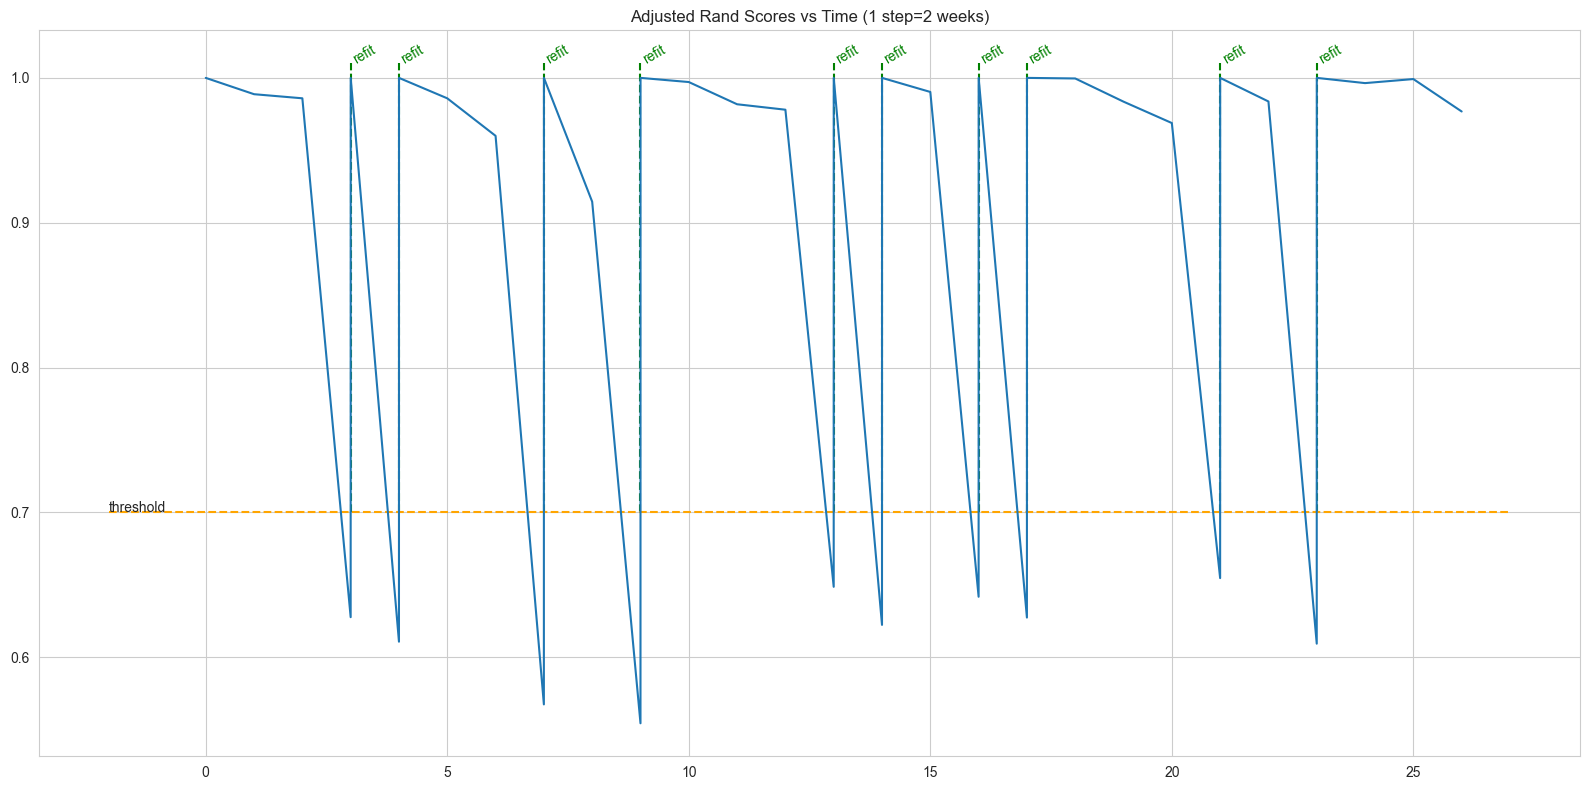

In [9]:
# Vars Init
orders_df = get_dataset('orders')
scores = {}
actual_model = []
threshold = .7
fig, ax = plt.subplots(figsize=(16, 8))
# Test every x weeks
delta_step = 2

# Init first loop on first Year
endtime = orders_df["order_purchase_timestamp"].min() + np.timedelta64(52, "W")
X = extract_features(endtime)
print(X.shape)

# Model Pipeline
model = make_cls_pipeline(X)
# Fit Model_t1 with X_t1
cls0_y0 = model.fit_predict(X)

actual_model = model.steps[-1][1]
scores[0] = 1

# Range from Week 52
_range = int(52/delta_step)+1
# Loop over week steps range
for i in range(1, _range):
    print("== "*20)
    # Data extraction filter by endtime (min + delta)
    delta = np.timedelta64(52 + i * delta_step, "W")
    endtime = orders_df["order_purchase_timestamp"].min() + delta 
    X = extract_features(endtime)
    print(X.shape)
    
    # Predict Model_t0 with X_t1
    model0 = make_cls_pipeline(X, actual_model)
    cls0_y1 = model0.predict(X)
    
    # Model Pipeline
    model = make_cls_pipeline(X)
    # Fit Model_t1 with X_t1
    cls1_y1 = model.fit_predict(X)
    
    # Score both results
    score = adjusted_rand_score(cls1_y1, cls0_y1)
    scores[i] = score
    print(f"==> ARI score: {score:.2f}")
    
    # Check Score to refit actual model 
    if score < threshold :
        print("Refit")
        # Plot score=1 because of refit
        scores[i+.001] = 1
        # Save refitted model as actual model
        actual_model = model.steps[-1][1]
        # Plot Refit
        ax.vlines(i,threshold,1.01, colors='g', linestyles='--', label='refit')
        ax.text(i,1.01, 'refit', fontsize=10, color='g', rotation=30)

# Plot Thresold 
ax.hlines(threshold, xmin=-2, xmax=_range, colors='orange', linestyles='--', label='threshold')
ax.text(-2,threshold, 'threshold', fontsize=10)

# Plot Scores over time
sns.lineplot(x=scores.keys(), y=scores.values(), ax=ax, legend=False)
ax.set_title(f"Adjusted Rand Scores vs Time (1 step={delta_step} weeks)")
fig.tight_layout()
plt.show()